<b><h1>CNN model for wood species identification</h1></b>
### 3 models can be used:
##### - A basic testing model to check overall functionality of system
##### - ResNET
##### - VGG
##### - Inception

In [1]:
 from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)

import matplotlib.pyplot as plt
import math
import numpy as np
import os
from PIL import Image
import sys
import xml.etree.ElementTree as ET  
from urllib.request import urlretrieve
try:
    from urllib.request import urlopen 
except ImportError: 
    from urllib import urlopen

from cntk import load_model
% matplotlib inline
import cntk as C
import cntk.io.transforms as xforms
print(C.__file__)

/home/william/anaconda3/lib/python3.5/site-packages/cntk/cntk_py_init.py:56: UserWarning: Unsupported Linux distribution (ubuntu-18.04). CNTK supports Ubuntu 16.04 and above, only.
  warnings.warn('Unsupported Linux distribution (%s-%s). CNTK supports Ubuntu 16.04 and above, only.' % (__my_distro__, __my_distro_ver__))
/home/william/anaconda3/lib/python3.5/site-packages/cntk/cntk_py_init.py:98: UserWarning: 

################################################ Missing optional dependency (GPU-Specific) ################################################
   CNTK may crash if the component that depends on those dependencies is loaded.
   Visit https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Linux-Python#optional-gpu-specific-packages for more information.
############################################################################################################################################
If you intend to use CNTK without GPU support, you can ignore the (likely) GPU-specific warn

/home/william/anaconda3/lib/python3.5/site-packages/cntk/__init__.py


In [2]:
# cheking if CPU or GPU best for training should be CPU here
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(1))

<b><h1>Reading data files: </h1></b>
##### - XML mean file
##### - Data map for train and test

In [3]:
# reading input data
envvar = 'CNTK_EXTERNAL_TESTDATA_SOURCE_DIRECTORY'
def is_test(): return envvar in os.environ

data_path = os.path.join('data','wood')

# model dimensions
image_height = 200
image_width = 200
num_channels = 3
num_classes = 12

#defining data readers for training and evaluation

def create_reader(map_file, mean_file, train):
    print('Reading map file: {}'.format(map_file))
    print('Reading mean file: {}'.format(mean_file))
    
    transforms = []
    
    if train:
        transforms += [
            xforms.crop(crop_type='randomside', side_ratio=0.8) 
        ]
    transforms += [
        xforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear'),
        xforms.mean(mean_file)
    ]
    
    #deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        features = C.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = C.io.StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )))
    

In [4]:
# Create  train and test data readers
reader_train = create_reader(os.path.join(data_path, 'Train-Wood-Species-Map.txt'), 
                             os.path.join(data_path, 'Wood-Data-Mean.xml'), True)
reader_test  = create_reader(os.path.join(data_path, 'Test-Wood-Species-Map.txt'), 
                             os.path.join(data_path, 'Wood-Data-Mean.xml'), False)

Reading map file: data/wood/Train-Wood-Species-Map.txt
Reading mean file: data/wood/Wood-Data-Mean.xml
Reading map file: data/wood/Test-Wood-Species-Map.txt
Reading mean file: data/wood/Wood-Data-Mean.xml


<b><h1> Models</h1></b>

### Basic Model (used for testing overall system)

In [6]:
# Basic model used here to test functionality of overall system use for testing faster training 
def create_basic_model(input, out_dims):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        net = C.layers.Convolution((5,5), 1, pad=True)(input)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.MaxPooling((3,3), strides=(2,2))(net)
    
        net = C.layers.Dense(5)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Dense(out_dims, activation=C.softmax)(net)
    
    return net       

### VGG models

In [5]:
# VGG inspired model with dropout and batch normalisation
def create_VGGsimp_model(input, out_dims):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        net = C.layers.Convolution((3,3), 32, pad=True)(input)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Convolution((3,3), 32, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.MaxPooling((2,2), strides=(2,2))(net)
        
        net = C.layers.Convolution((3,3), 64, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Convolution((3,3), 64, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.MaxPooling((2,2), strides=(2,2))(net)
        
        net = C.layers.Convolution((3,3), 128, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Convolution((3,3), 128, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.MaxPooling((2,2), strides=(2,2))(net)
        
        net = C.layers.Convolution((3,3), 256, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Convolution((3,3), 256, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.MaxPooling((2,2), strides=(2,2))(net)
        
        net = C.layers.Convolution((3,3), 512, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Convolution((3,3), 512, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.MaxPooling((2,2), strides=(2,2))(net)
        
        net = C.layers.Dense(2048)(net)
        net = C.layers.Dropout(0.5)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Dense(2048)(net)
        net = C.layers.Dropout(0.5)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Dense(out_dims, activation=C.softmax)(net)
    
    return net   

In [5]:
# VGG inspired model with dropout and batch normalisation
def create_VGG_model(input, out_dims):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        net = C.layers.Convolution((3,3), 64, pad=True)(input)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Convolution((3,3), 64, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.MaxPooling((2,2), strides=(2,2))(net)
        
        net = C.layers.Convolution((3,3), 128, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Convolution((3,3), 128, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.MaxPooling((2,2), strides=(2,2))(net)
        
        net = C.layers.Convolution((3,3), 256, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Convolution((3,3), 256, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.MaxPooling((2,2), strides=(2,2))(net)
        
        net = C.layers.Convolution((3,3), 512, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Convolution((3,3), 512, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.MaxPooling((2,2), strides=(2,2))(net)
        
        net = C.layers.Convolution((3,3), 512, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Convolution((3,3), 512, pad=True)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.MaxPooling((2,2), strides=(2,2))(net)
        
        net = C.layers.Dense(4096)(net)
        net = C.layers.Dropout(0.5)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Dense(2048)(net)
        net = C.layers.Dropout(0.5)(net)
        net = C.layers.BatchNormalization(map_rank=1)(net)
        net = C.layers.Dense(out_dims, activation=C.softmax)(net)
    
    return net   

### Resnet model

In [36]:
# load pretrained resnet model
resnet_model = C.load_model('PretrainedModels/Resnet_18.model')

# modify input and output layer of model
# to match wood data
features_node = C.logging.graph.find_by_name(resnet_model, 'features')
last_node = C.logging.graph.find_by_name(resnet_model, 'z.x')
# node_outputs = C.logging.get_node_outputs(resnet_model)
# for l in node_outputs: print(" {0} {1}".format(l.name, l.shape))
print(features_node)
print(last_node)

Input('features', [#, ], [3 x 224 x 224])
z.x: Pooling(z.x.x.r: SequenceOver[][Tensor[512,7,7]]) -> SequenceOver[][Tensor[512,1,1]]


In [6]:
# transfer clone all layers allowing to train new weights

cloned_layers = C.combine([last_node.owner]).clone(
                C.CloneMethod.clone,
                {features_node: C.placeholder(name='features')})

# features_input = C.input_variable((num_channels, image_height, image_width), name='features')
def create_resnet_model(input, out_dims):
    
    net = cloned_layers(input)
    net = C.layers.Dense(out_dims, activation=C.softmax)(net) 
    
    return net

### Inception Model

In [47]:
# load pretrained resnet model
inception_model = C.load_model('PretrainedModels/BNInception_ImageNet_Caffe.model')

# modify input and output layer of model
# to match wood data
features_node = C.logging.graph.find_by_name(inception_model, 'feature')
last_node = C.logging.graph.find_by_name(inception_model, 'pool5/drop_7x7_s1')
# node_outputs = C.logging.get_node_outputs(inception_model)
# for l in node_outputs: print(" {0} {1}".format(l.name, l.shape))
print(features_node)
print(last_node)

None
pool5/drop_7x7_s1: Dropout(pool5/7x7_s1: Tensor[1024,1,1]) -> Tensor[1024,1,1]


In [ ]:
# transfer clone all layers allowing to train new weights

cloned_layers = C.combine([last_node.owner]).clone(
                C.CloneMethod.clone,
                {features_node: C.placeholder(name='features')})

# features_input = C.input_variable((num_channels, image_height, image_width), name='features')
def create_inception_model(input, out_dims):
    
    net = cloned_layers(input)
    net = C.layers.Dense(out_dims, activation=C.softmax)(net) 
    
    return net

<b><h1> Training (with basic test result)</h1></b>

##### Skip to [here](#trained_model), to skip training

In [6]:
# Training and testing network
def train_and_test(reader_train, reader_test, max_epochs, model_func, model_name, saving_rate=5):
    
    run_number = 0 # multiple of 5
    # saving trainer location
    chk = 'checkpoints/{}/test_run_1/trainer_{}_{}.dnn'.format(model_name, model_name, str(run_number))
    # input containers for labels and features of data\
    input_var = C.input_variable((num_channels, image_height, image_width))
    label_var = C.input_variable(num_classes)
    
    # Normalize the input data (improves performance)
    feature_scale = 1.0 / 256
    input_var_norm = C.element_times(feature_scale, input_var)
    
    # apply model to input
    z = model_func(input_var_norm, out_dims=12)
    
    #
    # Training section
    #
    
    # defining loss function and metric for training
    
    # loss and metric
    ce = C.cross_entropy_with_softmax(z, label_var)
    pe = C.classification_error(z, label_var)
    
    # training configuration
    epoch_size = 5708 # number of testing samples
    minibatch_size = 64 # may need adjusting based on system memory
    
    # training parameters
    lr_per_minibatch = C.learning_parameter_schedule([0.05] * 50 + [0.01],
                                                    epoch_size=epoch_size)
    momentums        = C.momentum_schedule(0.9, minibatch_size = minibatch_size)
    l2_reg_weight   = 0.001
    
    #trainer object
    learner = C.momentum_sgd(z.parameters,
                            lr = lr_per_minibatch,
                            momentum = momentums,
                            l2_regularization_weight = l2_reg_weight)
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=max_epochs)
    
    #initialize trainer object 
    trainer = C.Trainer(z, (ce,pe), [learner], [progress_printer])
    
    # restore from checkpoint 
    if os.path.exists(chk):
        print('Restoring from checkpoint')
        mb_source_state = trainer.restore_from_checkpoint(chk)
        reader_train.restore_from_checkpoint(mb_source_state)
    else:
        print('Random Init')
        
    
            
    # define mapping from reader streams to network inputs
    input_map = {
        input_var: reader_train.streams.features,
        label_var: reader_train.streams.labels
    }
    
    C.logging.log_number_of_parameters(z) ; print()
    
    # perform model training
    batch_index = 0 
    plot_data = {'batchindex':[], 'loss':[], 'error':[]}
    for epoch in range(max_epochs): # loop over epochs
        sample_count = 0
        
        while sample_count < epoch_size: # loop over minibatches in the epoch
            data = reader_train.next_minibatch(min(minibatch_size, epoch_size - sample_count),
                                              input_map=input_map) # fetch the gooood minibacth
            trainer.train_minibatch(data)                          # updat model with da good minibatch
            
            sample_count += data[label_var].num_samples            # count number of samples processed
            
            # display results
            plot_data['batchindex'].append(batch_index)
            plot_data['loss'].append(trainer.previous_minibatch_loss_average)
            plot_data['error'].append(trainer.previous_minibatch_evaluation_average)
            
            batch_index += 1
        # checkpoint saving
        if (epoch+1) % saving_rate == 0:
            mb_source_chk = reader_train.get_checkpoint_state()
            trainer.save_checkpoint('checkpoints/{}/test_run_1/trainer_{}_{}.dnn'.format(model_name, model_name, str(epoch+run_number+1)), mb_source_chk)
            z.save('model/{}/test_run_1/{}_0.1_{}.model'.format(model_name, model_name, str(epoch+run_number+1)))
            
            
        trainer.summarize_training_progress()
    #
    # Evaluation action
    #
    epoch_size     = 2836
    minibatch_size = 32

    # process minibatches and evaluate the model
    metric_numer    = 0
    metric_denom    = 0
    sample_count    = 0
    minibatch_index = 0

    while sample_count < epoch_size:
        current_minibatch = min(minibatch_size, epoch_size - sample_count)

        # Fetch next test min batch.
        data = reader_test.next_minibatch(current_minibatch, input_map=input_map)

        # minibatch data to be trained with
        metric_numer += trainer.test_minibatch(data) * current_minibatch
        metric_denom += current_minibatch

        # Keep track of the number of samples processed so far.
        sample_count += data[label_var].num_samples
        minibatch_index += 1

    print("")
    print("Final Results: Minibatch[1-{}]: errs = {:0.1f}% * {}".format(minibatch_index+1, (metric_numer*100.0)/metric_denom, metric_denom))
    print("")

    # Visualize training result:
    window_width = 8
    loss_cumsum  = np.cumsum(np.insert(plot_data['loss'], 0, 0))
    error_cumsum = np.cumsum(np.insert(plot_data['error'], 0, 0))
    
    # Moving Average
    plot_data['batchindex'] = np.insert(plot_data['batchindex'], 0, 0)[window_width:]
    plot_data['avg_loss']   = (loss_cumsum[window_width:] - loss_cumsum[:-window_width]) / window_width
    plot_data['avg_error']  = (error_cumsum[window_width:] - error_cumsum[:-window_width]) / window_width
    
    plt.figure(1)
    plt.subplot(211)
    plt.plot(plot_data["batchindex"], plot_data["avg_loss"], 'b--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.title('Minibatch run vs. Training loss ')

    plt.show()

    plt.subplot(212)
    plt.plot(plot_data["batchindex"], plot_data["avg_error"], 'r--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Label Prediction Error')
    plt.title('Minibatch run vs. Label Prediction Error ')
    plt.show()
    
    return z
    

### Basic model (for testing)

In [9]:
# train basic model from random init
pred_basic_model = train_and_test(reader_train,
                     reader_test,
                     max_epochs=5,    # change number of epochs here
                     model_func=create_basic_model)

NameError: name 'create_basic_model' is not defined

### VGG model

In [7]:
# train VGG model
VGG_model = train_and_test(reader_train,
                     reader_test,
                     max_epochs=5,            # change number of epochs here
                     model_func=create_VGG_model,
                    model_name='VGG')

Random Init
Training 93339980 parameters in 50 parameter tensors.



RuntimeError: std::bad_alloc

### Resnet model

In [67]:
# train resnet model
resnet_model = train_and_test(reader_train,
                     reader_test,
                     max_epochs=1,            # change number of epochs here
                     model_func=create_resnet_model,
                     model_name='resnet')

TypeError: argument features's type SequenceOver[][Tensor[3,224,224]] is incompatible with the type Tensor[3,200,200] of the passed Variable

### Inception Model

In [63]:
# train resnet model
resnet_model = train_and_test(reader_train,
                     reader_test,
                     max_epochs=1,            # change number of epochs here
                     model_func=create_inception_model,
                     model_name='inception')

TypeError: argument features's type SequenceOver[][Tensor[3,224,224]] is incompatible with the type Tensor[3,200,200] of the passed Variable

<b><h1>Testing models</h1></b>
##### Need to add better output option

In [5]:
# location of test data returns list of filenames and idx
def read_test_img(filename):
    with open(filename,'r') as f:
        lines = f.readlines()
        filenames_idx = list()
        for line in range(len(lines)):
            filenames_idx.append(lines[line].split('\t'))    
        f.close()
        return filenames_idx
    
# create list of features or labels
def image_lbl_list(mapfile, features):
    
    if features:
        images = list()
        for img_num in range(len(mapfile)):
            img = np.asarray(Image.open(mapfile[img_num][0]), np.float32)
            img = np.ascontiguousarray(np.transpose(img, (2, 0, 1)))
            images.append(img)
        return images
    else:
        labels = np.zeros((len(mapfile),1))
        for lbl_num in range(len(mapfile)):
            labels[lbl_num] = mapfile[lbl_num][1]
        return np.float32(labels)

# test model on single image
def eval_single_image(model, image_path, mean_file):
    try:
            
        img = Image.open(image_path)
        img = np.asarray(img, np.float32)- np.mean(mean_file)

        image_data = img[..., [2, 1, 0]]
        image_data = np.ascontiguousarray(np.rollaxis(image_data, 2))
        output = np.squeeze(model.eval({model.arguments[0]:[image_data]}))

        # return probabilities

        return output

    except FileNotFoundError:
            print('Could not open (skipping file): {}'.format(image_path))
            return['None'] 
        
# eval all the test images     
def eval_test_images(images_lbls, model, mean_file):
    num_correct = 0
    for i in range(len(images_lbls)):
        image_path = images_lbls[i][0]
        lbl = int(images_lbls[i][1])
        pred = eval_single_image(model, image_path, mean_file)
        pred = np.argmax(pred)
        if pred == lbl:
            num_correct = num_correct + 1
            
        if i%500 == 0 and i != 0:
            print('Processed 500 test images, current accuracy: {:0.2f}%'.format(100 * num_correct/i))
    print('Total Accuracy: {:0.2f}%'.format(100 * num_correct / len(images_lbls)))
    

### VGG model 

Top 3 prediction
Predicted label: 6, with accuracy: 96.85%
Predicted label: 4, with accuracy: 2.86%
Predicted label: 0, with accuracy: 0.12%
True label: 4



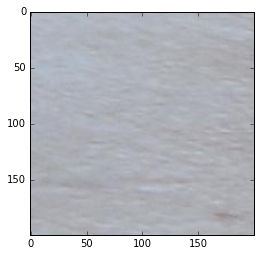

In [58]:
# Test Single image with basic model
image_num = 15
tree = ET.parse('data/wood/Wood-Data-Mean.xml')
meanData = tree.findtext('MeanImg/data').split()
meanData = np.asarray(meanData,dtype=np.float32)
pred_basic_model = load_model('model/VGG/test_run_2/VGG_0.1_80.model')
file_path_test = 'data/wood/Test-Wood-Species-Map.txt'
filenames_lbls = read_test_img(file_path_test)
result = eval_single_image(pred_basic_model, filenames_lbls[image_num][0], meanData)
img_show = plt.imread(filenames_lbls[image_num][0])
plt.imshow(img_show)
print('Top 3 prediction')
predicted_label = np.argsort(result)[::-1]
predicted_label = predicted_label[0:3]
accuracy = np.sort(result)[::-1]
accuracy = accuracy[0:3] * 100
for i in range(3):
    print('Predicted label: {}, with accuracy: {:.2f}%'.format(predicted_label[i], accuracy[i]))
print('True label: {}'.format(filenames_lbls[image_num][1]))

In [8]:
### Test all images basic model
tree = ET.parse('data/wood/Wood-Data-Mean.xml')
meanData = tree.findtext('MeanImg/data').split()
meanData = np.asarray(meanData,dtype=np.float32)
model = load_model('model/VGG/test_run_3/VGG_0.1_20.model')
test_file_path = 'data/wood/Test-Wood-Species-Map.txt'
filenames_lbls = read_test_img(test_file_path)
eval_test_images(filenames_lbls,model, meanData)

Processed 500 test images, current accuracy: 48.20%
Processed 500 test images, current accuracy: 51.50%
Processed 500 test images, current accuracy: 51.07%
Processed 500 test images, current accuracy: 51.60%
Processed 500 test images, current accuracy: 51.36%
Total Accuracy: 51.06%


### Resnet Model

Top 3 prediction
Predicted label: 4, with accuracy: 56.30%
Predicted label: 5, with accuracy: 21.30%
Predicted label: 6, with accuracy: 9.76%
True label: 4



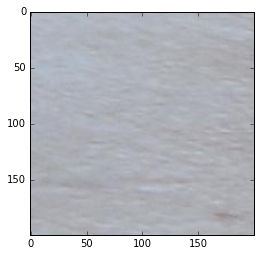

In [59]:
# Test Single image with basic model
image_num = 15
tree = ET.parse('data/wood/Wood-Data-Mean.xml')
meanData = tree.findtext('MeanImg/data').split()
meanData = np.asarray(meanData,dtype=np.float32)
pred_basic_model = load_model('model/resnet/test_run_2/resnet_0.1_30.model')
file_path_test = 'data/wood/Test-Wood-Species-Map.txt'
filenames_lbls = read_test_img(file_path_test)
result = eval_single_image(pred_basic_model, filenames_lbls[image_num][0], meanData)
img_show = plt.imread(filenames_lbls[image_num][0])
plt.imshow(img_show)
print('Top 3 prediction')
predicted_label = np.argsort(result)[::-1]
predicted_label = predicted_label[0:3]
accuracy = np.sort(result)[::-1]
accuracy = accuracy[0:3] * 100
for i in range(3):
    print('Predicted label: {}, with accuracy: {:.2f}%'.format(predicted_label[i], accuracy[i]))
print('True label: {}'.format(filenames_lbls[image_num][1]))

In [14]:
# Test all images basic model
tree = ET.parse('data/wood/Wood-Data-Mean.xml')
meanData = tree.findtext('MeanImg/data').split()
meanData = np.asarray(meanData,dtype=np.float32)
model = load_model('model/resnet/test_run_3/resnet_0.1_30.model')
test_file_path = 'data/wood/Test-Wood-Species-Map.txt'
filenames_lbls = read_test_img(test_file_path)
eval_test_images(filenames_lbls,model, meanData)

Processed 500 test images, current accuracy: 90.00%
Processed 500 test images, current accuracy: 90.30%
Processed 500 test images, current accuracy: 90.80%
Processed 500 test images, current accuracy: 90.60%
Processed 500 test images, current accuracy: 90.40%
Total Accuracy: 90.37%
